In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="rfYCcNnmeIoqGxOhC7RA")
project = rf.workspace("joseph-nelson").project("rock-paper-scissors")
version = project.version(1)
dataset = version.download("folder")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import pandas as pd
import numpy as np

In [ ]:
# Paths to dataset directories
train_dir = "Rock-Paper-Scissors-1/train/"
valid_dir = "Rock-Paper-Scissors-1/valid/"
test_dir = "Rock-Paper-Scissors-1/test/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16


In [ ]:
# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescaling for validation and test
valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Creating data generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


In [ ]:
def create_model(base_model_class, input_shape=(224, 224, 3), num_classes=3):
    base_model = base_model_class(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  # Freeze base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Initialize models
resnet_model = create_model(ResNet50)
efficientnet_model = create_model(EfficientNetB0)
mobilenet_model = create_model(MobileNetV2)


In [ ]:
# Training configuration
epochs = 15
learning_rate = 1e-4
patience = 5

# Function to compile, train, and return history
def compile_and_train(model, train_gen, val_gen, epochs, learning_rate, model_name):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'{model_name}_best_model.keras', monitor='val_accuracy', save_best_only=True)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping, checkpoint])
    return history

# Train each model and collect histories
resnet_history = compile_and_train(resnet_model, train_gen, valid_gen, epochs, learning_rate, 'ResNet50')
efficientnet_history = compile_and_train(efficientnet_model, train_gen, valid_gen, epochs, learning_rate, 'EfficientNetB0')
mobilenet_history = compile_and_train(mobilenet_model, train_gen, valid_gen, epochs, learning_rate, 'MobileNetV2')

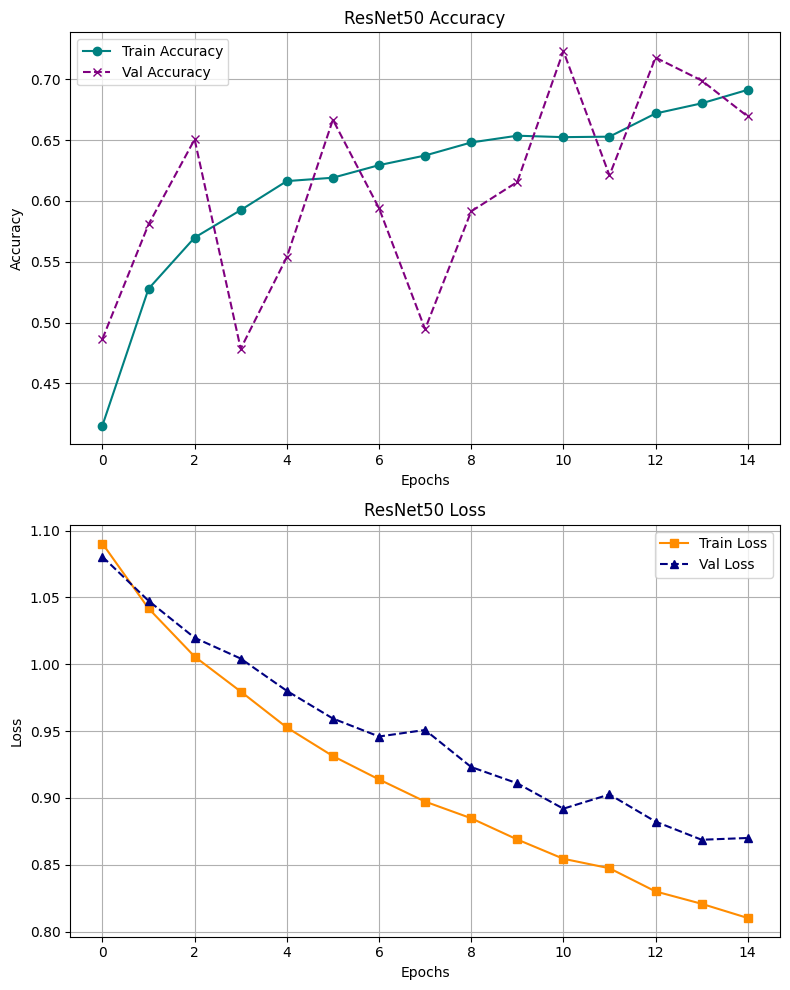

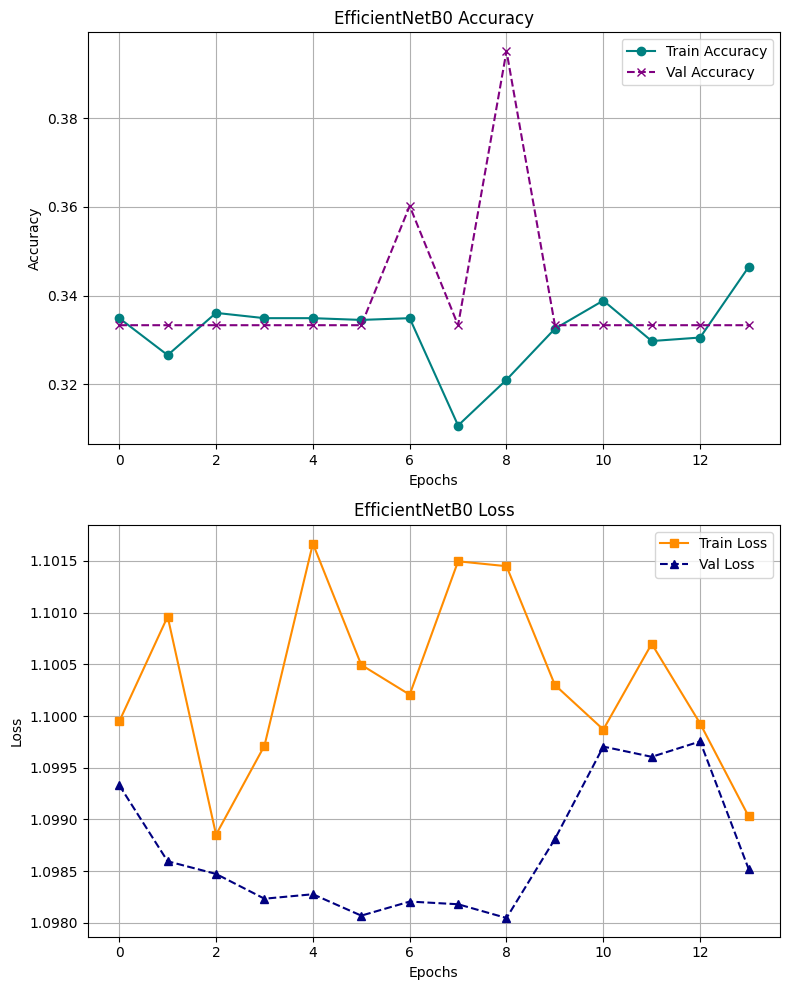

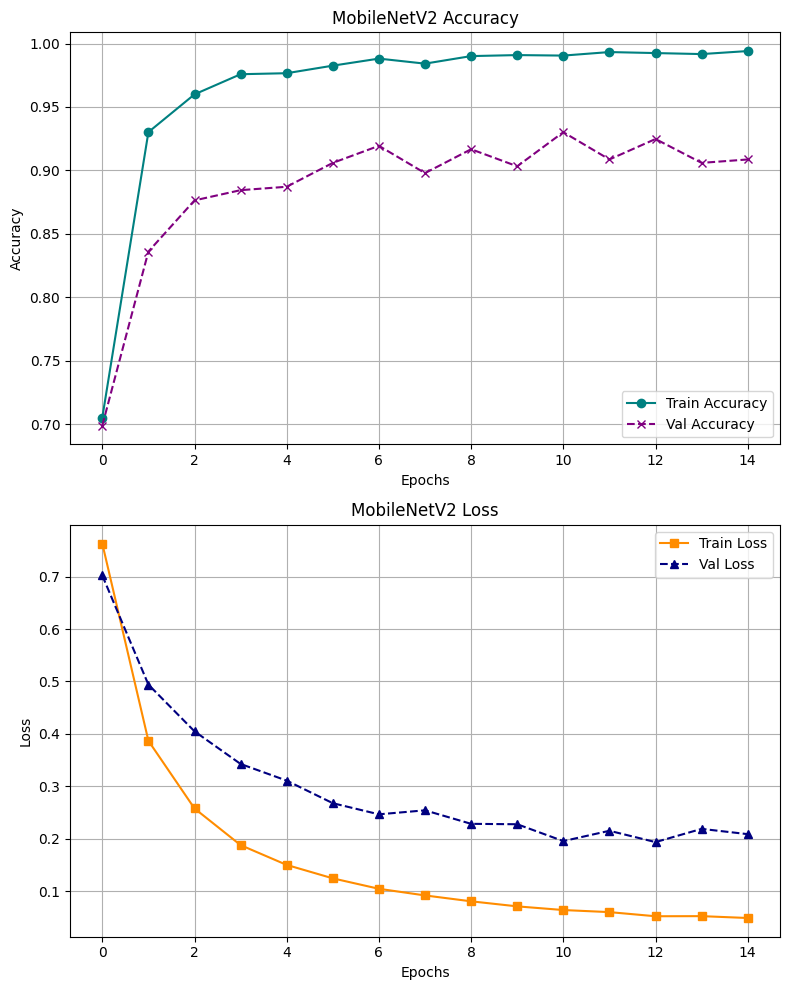

In [12]:
def plot_learning_curves(history, model_name):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))  # Vertical layout

    # Plot accuracy with different colors and markers
    ax1.plot(history.history['accuracy'], label='Train Accuracy', color='teal', marker='o', linestyle='-')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy', color='purple', marker='x', linestyle='--')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss with different colors and markers
    ax2.plot(history.history['loss'], label='Train Loss', color='darkorange', marker='s', linestyle='-')
    ax2.plot(history.history['val_loss'], label='Val Loss', color='navy', marker='^', linestyle='--')
    ax2.set_title(f'{model_name} Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Display learning curves for each model
plot_learning_curves(resnet_history, 'ResNet50')
plot_learning_curves(efficientnet_history, 'EfficientNetB0')
plot_learning_curves(mobilenet_history, 'MobileNetV2')


In [13]:
# Function to evaluate model and return metrics
def evaluate_model(model, test_gen, model_name):
    results = model.evaluate(test_gen, verbose=0)
    return {'Model': model_name, 'Test Accuracy': results[1], 'Test Loss': results[0]}

# Collect results for each model
results = []
results.append(evaluate_model(resnet_model, valid_gen, 'ResNet50'))
results.append(evaluate_model(efficientnet_model, valid_gen, 'EfficientNetB0'))
results.append(evaluate_model(mobilenet_model, valid_gen, 'MobileNetV2'))

# Display results in a DataFrame
results_df = pd.DataFrame(results)
print(results_df)


            Model  Test Accuracy  Test Loss
0        ResNet50       0.698925   0.868766
1  EfficientNetB0       0.395161   1.098046
2     MobileNetV2       0.924731   0.193486


Epoch 1/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.8351 - loss: 0.4550 - val_accuracy: 0.9382 - val_loss: 0.2338 - learning_rate: 0.0010
Epoch 2/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9927 - loss: 0.0572 - val_accuracy: 0.9086 - val_loss: 0.2490 - learning_rate: 0.0010
Epoch 3/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9954 - loss: 0.0318 - val_accuracy: 0.9005 - val_loss: 0.2730 - learning_rate: 0.0010
Epoch 4/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9974 - loss: 0.0212 - val_accuracy: 0.9382 - val_loss: 0.1756 - learning_rate: 0.0010


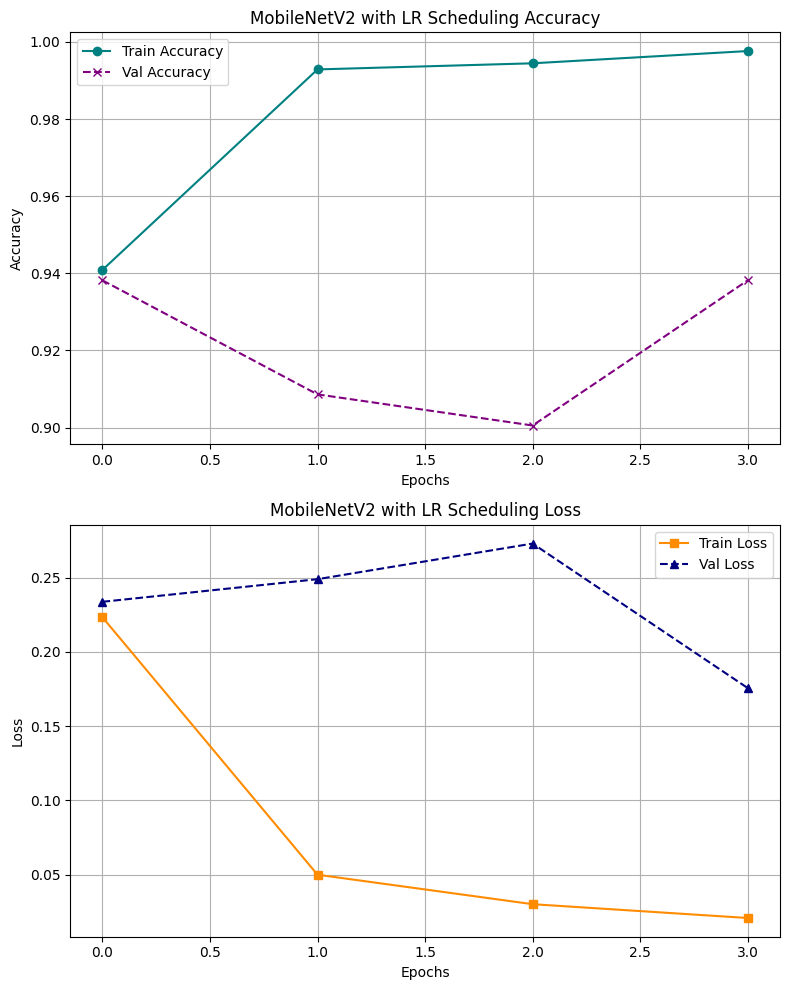

In [20]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning rate schedule function
def lr_schedule(epoch, lr):
    # Reduce learning rate every 5 epochs
    if epoch % 5 == 0 and epoch != 0:
        lr = lr * 0.5
    return lr

# Initialize the scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Reinitialize the MobileNet model to fine-tune with the new settings
mobilenet_model = create_model(MobileNetV2)

# Set up training configuration
initial_lr = 1e-3  # Start with a higher learning rate
patience = 3  # Reduce patience for early stopping to keep training efficient
epochs = 15

# Compile, train, and save the best model with early stopping and learning rate scheduling
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for early stopping, best model checkpointing, and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)
checkpoint = ModelCheckpoint('MobileNetV2_best_model.keras', monitor='val_accuracy', save_best_only=True)

# Training with the callbacks
mobilenet_history = mobilenet_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

# Plot learning curves after fine-tuning
plot_learning_curves(mobilenet_history, 'MobileNetV2 with LR Scheduling')


In [22]:
mobilenet_model.evaluate(test_gen)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9463 - loss: 0.2703 


[0.2521393299102783, 0.939393937587738]

### Major differences
1. **Dataset - Rock Paper Scissors from Roboflow**
2. **Models - ResNet50, EfficientNet, MobileNet**
3. **MobileNet best model, 92%**
4. **Tune MobileNet with LR Scheduling, Early Stopping; final accuracy 93.9%**